> This notebook replicates analysis from the Kavya's notebook Gbm_MINER_NetworkMappingIndependentDatasets.ipynb

In [2]:
import sys
import os
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import re
import subprocess
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time,datetime
from collections import Counter
from sklearn.manifold import TSNE
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
%matplotlib inline
plt.style.use('ggplot')
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
import miner_py3 as miner
import imp
import warnings
from tqdm.notebook import tqdm, trange
warnings.filterwarnings("ignore")
print("Last updated:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2022-07-11 10:27:43
Last updated: 2022-07-11 10:27:44


# Load data files

In [4]:
# define data and resulting model directory
dataDirectory = '/Volumes/omics4tb2/SYGNAL/GBM-Serdar/data/'
resultsDirectory='/Volumes/omics4tb2/SYGNAL/GBM-Serdar/MINER_All_ST030222/'
os.chdir(resultsDirectory)

# Load regulon info
regulonDf = pd.read_csv("regulonDf.csv",header=0,sep=",", index_col=0)
coherentMemberDf = pd.read_csv("coherentMembers.csv",header=0,index_col = 0, sep=",")
print("Loaded\n",
      "Regulons:", len(set(regulonDf['Regulon_ID'])))

Loaded
 Regulons: 3797


# Functions

## function to load and process expression data

In [15]:
def loadExpression(expressionData):
    arrayexpdf = miner.zerofilter(expressionData)     
    expdf = arrayexpdf
    expdf = expdf.fillna(0)
    expdf = miner.removeNullRows(expdf)
    expdf = miner.entropycheck(expdf)
    expressionData=miner.zscore(expdf)
    return expressionData 

## Function for Network mapping

In [13]:
def networkMapping(expressionData,regulonModules,label):
    t1 = time.time()
    # select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)

    referenceDictionary = regulonModules
    # create a background matrix used for statistical hypothesis testing
    bkgd = miner.backgroundDf(expressionData)
    # for each cluster, give samples that show high coherent cluster activity
    overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
    # for each clus|ter, give samples that show low coherent cluster activity
    underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
    # for each cluster, give samples that do not show coherent cluster activity
    dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
    # # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
    coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

    # write membership matrices to .csv file
    overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
    overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers" + label + ".csv"))
    underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
    underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers" + label + ".csv"))
    dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
    dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers" + label + ".csv"))
    coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
    coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers" + label + ".csv"))

    t2 = time.time()
    print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))
    return coherentMembers,overExpressedMembersMatrix,underExpressedMembersMatrix,dysregulatedMembersMatrix,coherentMembersMatrix,overExpressedMembers,underExpressedMembers,dysregulatedMembers

## Function to infer States

In [25]:
def inferStates(expressionData,label):
    # Infer transcriptional states
    minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
    referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
    primaryMatrix = overExpressedMembersMatrix
    primaryDictionary = overExpressedMembers
    secondaryMatrix = underExpressedMembersMatrix
    secondaryDictionary = underExpressedMembers

    states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
    states_dictionary = {str(i):states[i] for i in range(len(states))}
    
    # write results into a file
    miner.write_json(states_dictionary,os.path.join(resultsDirectory,"transcriptional_states" + label + ".json"))
    
    return states,centroidClusters,states_dictionary

## Function to infer States vs Programs

In [32]:
def inferStatesvsPrograms(transcriptional_programs,label):    
    # Get program list from MINER model
    program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

    dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
    mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]

    # Mosaic plot
    plt.figure(figsize=(5,5))
    plt.imshow(mtrx,cmap="bwr",vmin=-1.5,vmax=1.5,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
    plt.grid(False)
    plt.savefig(os.path.join(resultsDirectory,"mosaic_all" + label + ".pdf"),bbox_inches="tight")

    # Determine activity of transcriptional programs in each sample
    statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"transcriptional_programs" + label + ".pdf"))

    # Cluster patients into subtypes and give the activity of each program in each subtype
    programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states" + label + ".pdf"),showplot=False)
    
    # Plot Programs vs States heatmap
    #import seaborn as sns
    #import matplotlib.pylab as plt
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.heatmap(programsVsStates,vmax=1, vmin=-1,  cmap="bwr",xticklabels=2, yticklabels=20,cbar=False)
    #ax.grid(False)

    plt.ylabel("Transcriptional programs",fontsize=14)
    plt.xlabel("Transcriptional states",fontsize=14)
    plt.show()

    return program_list, statesDf, programsVsStates

# Network Mapping for independent datasets

## Rembrandt Data set

### Load regulons and expressiondata

In [37]:
# Load regulons
regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))

# Load expression file and preprocess with MINER and write to file
expressionDataRembrandtFile=os.path.join(dataDirectory,"Rembrandt_MinerInput.csv")
expressionDataRembrandt = miner.preprocess(expressionDataRembrandtFile,convert_ids = False)
expressionDataRembrandt.to_csv(os.path.join(dataDirectory,"Rembrandt_MinerInputFiltered.csv"))
expressionDataRembrandt.head()

completed z-transformation.


,X508984.CEL,X545226.CEL,X547038.CEL,X548457.CEL,X549279.CEL,X550239.CEL,X550715.CEL,X554082.CEL,X570013.CEL,X602958.CEL,...,HF1587.CEL,HF1589.CEL,HF1608.CEL,HF1613.CEL,HF1618.CEL,HF1628.CEL,HF1640.CEL,HF1667.CEL,HF1671.CEL,HF1702.CEL
ENSG00000198755,0.089840,1.748056,-0.191369,1.542965,1.781557,0.849090,1.213725,2.057104,0.988007,0.156870,...,0.089840,0.354508,0.849090,0.893844,0.437066,0.988007,-1.564419,-1.014732,1.478403,0.068960
ENSG00000125462,0.317186,0.148616,1.474313,2.122011,0.990989,-0.294898,2.122011,1.596259,0.164937,-1.954442,...,1.116530,1.380328,0.553147,0.641614,0.608342,1.474313,-0.784504,-0.473855,1.116530,1.380328
ENSG00000118816,-1.569936,1.761908,0.488000,1.022108,1.524324,-0.584027,0.791543,1.276632,-1.037224,-0.191839,...,1.694127,-0.676278,-0.910697,0.816951,0.144083,-0.105159,1.610303,0.623370,-0.420495,0.144083
ENSG00000197746,-0.848931,-0.848931,1.323455,0.801147,-0.171449,-0.068741,0.369066,-2.439761,-1.181360,1.155918,...,-0.465592,-0.752550,-0.698988,0.296178,-1.181360,-1.789474,0.218022,0.955298,-0.068741,-0.752550
ENSG00000115306,-1.332145,-0.351488,1.670023,1.056262,0.626084,0.355914,1.124192,-1.355989,1.371770,-0.987824,...,0.481840,-0.202544,-0.791703,-0.041073,-0.296322,-0.303663,2.966652,1.371770,0.913737,0.435976


### Network Mapping

In [ ]:
# run network mapping
coherentMembers,overExpressedMembersMatrix,underExpressedMembersMatrix,dysregulatedMembersMatrix,coherentMembersMatrix,overExpressedMembers,underExpressedMembers,dysregulatedMembers = networkMapping(expressionDataRembrandt,regulonModules,"Rembrandt")

### Visualize network activity

Text(0.5, 0, 'Samples')

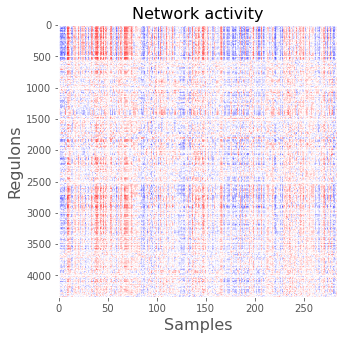

In [22]:
#visualize network activity across individual samples
plt.figure(figsize=(5,5))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

### Infer States

In [27]:
states,centroidClusters,states_dictionary = inferStates(expressionDataRembrandt,"Rembrandt")

Beginning subtype inference
completed subtype inference in 0.09 minutes


### Infer States vs Programs

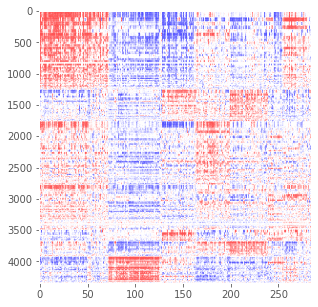

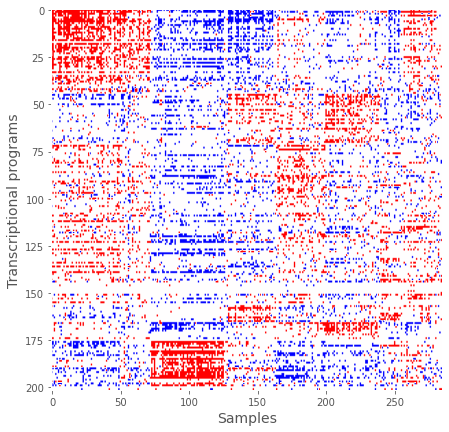

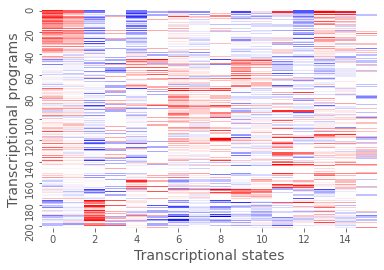

In [33]:
# load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(resultsDirectory,'transcriptional_programs.json'))

# run States vs Program inference
program_list, statesDf, programsVsStates = inferStatesvsPrograms(transcriptional_programs,"Rembrandt")

## French Data set

### Load regulons and expressiondata

In [39]:
# Load regulons
regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))

# Load expression file and preprocess with MINER and write to file
expressionDataFrenchFile=os.path.join(dataDirectory,"French_MinerInput.csv")
expressionDataFrench = miner.preprocess(expressionDataFrenchFile,convert_ids = False)
expressionDataFrench.to_csv(os.path.join(dataDirectory,"French_MinerInputFiltered.csv"))
expressionDataFrench.head()

completed z-transformation.


,X007.CEL,X008.CEL,X009.CEL,X011.CEL,X013.CEL,X020.CEL,X021.CEL,X023.CEL,X025.CEL,X031.CEL,...,X649.CEL,X651.CEL,X652.CEL,X656.CEL,X657.CEL,X662.CEL,X670.CEL,X691.CEL,X697.CEL,X704.CEL
Gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,-3.727322,-0.663610,0.057178,0.370097,-0.075228,0.924201,-0.110487,0.172487,-0.477702,-2.754752,...,-0.170733,0.304357,1.188003,2.055741,0.098903,0.942713,0.289446,0.181077,0.454846,-0.003155
ENSG00000000419,-1.125520,-0.951590,-0.379176,-0.093330,-0.243510,2.150805,-0.731401,0.253915,-0.511280,-1.145143,...,-0.888449,-0.370325,-0.892433,-0.041322,-1.861270,-0.237273,0.511197,-1.840574,-2.078833,-1.359568
ENSG00000000457,-1.709384,-1.322574,0.680733,-0.925667,1.224055,0.472007,-1.272919,1.254048,-1.280447,0.267716,...,0.944760,-0.093277,-0.023459,-0.049153,0.011600,1.283786,0.302438,-1.365565,0.210175,-0.510148
ENSG00000000938,-0.653812,-0.817783,0.141579,-0.531846,-1.122799,-0.726144,-0.621275,-1.117092,-0.809874,-1.483591,...,0.561148,1.380778,1.854692,-0.024375,0.083507,-1.068060,-1.111848,2.186074,-1.075345,1.363330
ENSG00000000971,-0.224295,-0.846167,1.663095,0.632086,-0.337413,1.795775,-0.582974,-0.984579,-1.085541,-0.861847,...,-0.655759,-0.558657,-0.626756,0.833922,1.188437,-1.131112,-0.358011,-0.018581,0.020827,-0.478575


### Network Mapping

In [40]:
# run network mapping
coherentMembers,overExpressedMembersMatrix,underExpressedMembersMatrix,dysregulatedMembersMatrix,coherentMembersMatrix,overExpressedMembers,underExpressedMembers,dysregulatedMembers = networkMapping(expressionDataFrench,regulonModules,"French")

done!
done!
done!
done!
Completed patient mapping in 0.88 minutes


### Visualize network activity

Text(0.5, 0, 'Samples')

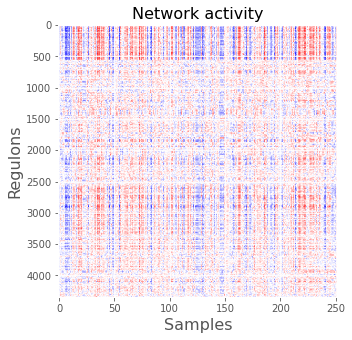

In [41]:
#visualize network activity across individual samples
plt.figure(figsize=(5,5))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

### Infer States

In [42]:
states,centroidClusters,states_dictionary = inferStates(expressionDataFrench,"French")

Beginning subtype inference
completed subtype inference in 0.07 minutes


### Infer States vs Programs

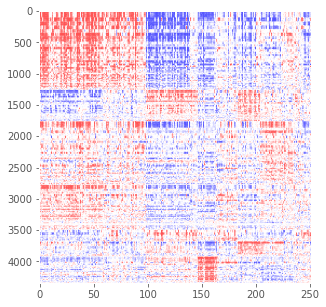

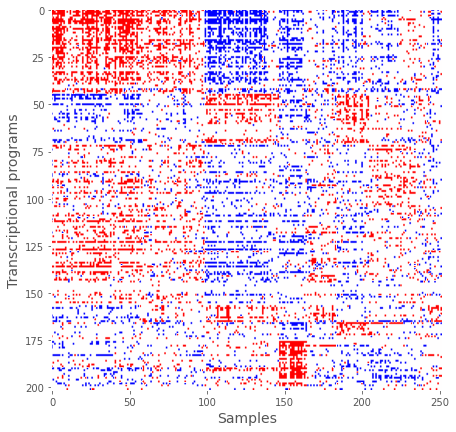

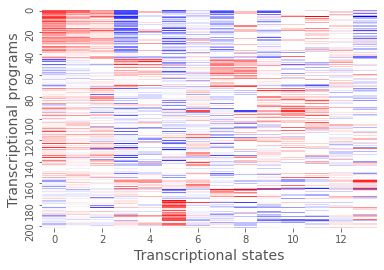

In [43]:
# load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(resultsDirectory,'transcriptional_programs.json'))

# run States vs Program inference
program_list, statesDf, programsVsStates = inferStatesvsPrograms(transcriptional_programs,"French")

## Ivy Atlas Data set

### Load regulons and expressiondata

In [44]:
# Load regulons
regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))

# Load expression file and preprocess with MINER and write to file
expressionDataIvyAtlasFile=os.path.join(dataDirectory,"IvyAtlas_GBM_referenceHistology_MinerInput.csv")
expressionDataIvyAtlas = miner.preprocess(expressionDataIvyAtlasFile,convert_ids = False)
expressionDataIvyAtlas.to_csv(os.path.join(dataDirectory,"IvyAtlas_GBM_referenceHistology_MinerInputFiltered.csv"))
expressionDataIvyAtlas.head()

completed z-transformation.


,E09137_T,E09137B_T,E09138_T,E09139_T,E09192_T,E09214_T,E09233_T,E09278_T,E09278B_T,E09331_T,...,HF1628_T,HF1640_T,HF1667_T,HF1671_T,MD545226_T,MD602958_T,MD607103_T,MD607216_T,MD608660_T,MD621233_T
Gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,-0.157244,-1.487666,0.792441,-0.002983,0.905410,0.743716,-0.118262,-0.437259,1.330667,-1.091107,...,0.724961,-2.991678,-1.141903,-0.344731,0.463603,0.668636,0.013403,-0.360151,0.348956,-0.089567
ENSG00000000005,-0.570573,-1.054950,0.582184,-0.544052,-0.475816,-0.363004,-0.647314,-0.511613,0.114308,-0.332859,...,-0.722741,-0.012034,-0.072462,-0.006011,-0.373435,-0.748023,-0.335285,-0.165715,-1.048860,3.809384
ENSG00000000419,-0.406218,0.191526,-0.820229,0.521124,-0.456551,-1.050282,0.501958,-0.295316,-1.224787,0.169628,...,1.319591,-0.841507,-0.802508,-0.054479,0.067897,-0.305252,0.592051,0.044196,2.059453,-2.407702
ENSG00000000457,0.249654,-0.677343,-0.200098,0.791122,0.176697,-0.651769,2.330217,1.298664,0.078699,-0.500704,...,0.703914,-2.164427,-0.932956,0.556306,0.947206,-0.055105,-0.630831,-0.835772,-0.472989,-2.110933
ENSG00000000460,-1.178553,-1.865024,-0.155026,0.832223,-0.566461,-0.775006,-0.326162,-0.507342,-0.607333,0.298275,...,1.350888,-1.684807,-1.185296,0.516861,1.229170,1.851960,1.444561,0.578413,-0.343970,-0.575763


### Network Mapping

In [45]:
# run network mapping
coherentMembers,overExpressedMembersMatrix,underExpressedMembersMatrix,dysregulatedMembersMatrix,coherentMembersMatrix,overExpressedMembers,underExpressedMembers,dysregulatedMembers = networkMapping(expressionDataIvyAtlas,regulonModules,"IvyAtlas")

done!
done!
done!
done!
Completed patient mapping in 0.75 minutes


### Visualize network activity

Text(0.5, 0, 'Samples')

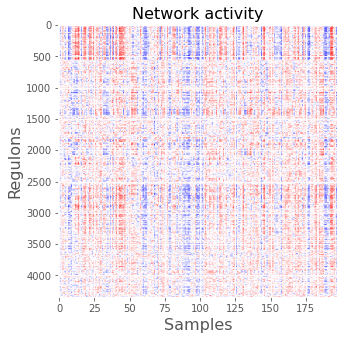

In [46]:
#visualize network activity across individual samples
plt.figure(figsize=(5,5))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

### Infer States

In [47]:
states,centroidClusters,states_dictionary = inferStates(expressionDataIvyAtlas,"IvyAtlas")

Beginning subtype inference
completed subtype inference in 0.05 minutes


### Infer States vs Programs

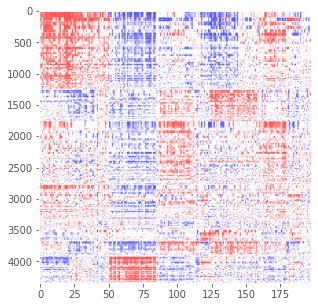

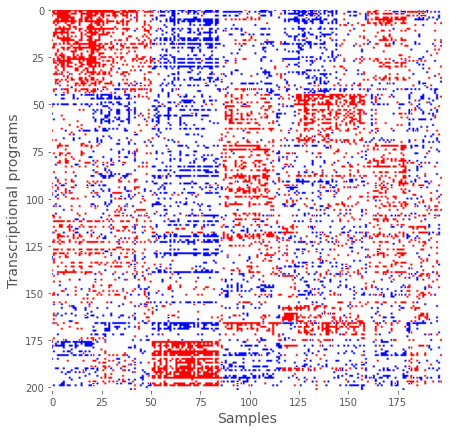

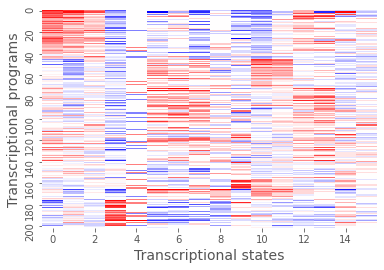

In [48]:
# load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(resultsDirectory,'transcriptional_programs.json'))

# run States vs Program inference
program_list, statesDf, programsVsStates = inferStatesvsPrograms(transcriptional_programs,"IvyAtlas")

## GSE7696 Data set

### Load regulons and expressiondata

In [44]:
# Load regulons
regulonModules = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))

# Load expression file and preprocess with MINER and write to file
expressionDataGSE7696File=os.path.join(dataDirectory,"IvyAtlas_GBM_referenceHistology_MinerInput.csv")
expressionDataGSE7696 = miner.preprocess(expressionDataIvyAtlasFile,convert_ids = False)
expressionDataGSE7696.to_csv(os.path.join(dataDirectory,"IvyAtlas_GBM_referenceHistology_MinerInputFiltered.csv"))
expressionDataGSE7696.head()

completed z-transformation.


,E09137_T,E09137B_T,E09138_T,E09139_T,E09192_T,E09214_T,E09233_T,E09278_T,E09278B_T,E09331_T,...,HF1628_T,HF1640_T,HF1667_T,HF1671_T,MD545226_T,MD602958_T,MD607103_T,MD607216_T,MD608660_T,MD621233_T
Gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,-0.157244,-1.487666,0.792441,-0.002983,0.905410,0.743716,-0.118262,-0.437259,1.330667,-1.091107,...,0.724961,-2.991678,-1.141903,-0.344731,0.463603,0.668636,0.013403,-0.360151,0.348956,-0.089567
ENSG00000000005,-0.570573,-1.054950,0.582184,-0.544052,-0.475816,-0.363004,-0.647314,-0.511613,0.114308,-0.332859,...,-0.722741,-0.012034,-0.072462,-0.006011,-0.373435,-0.748023,-0.335285,-0.165715,-1.048860,3.809384
ENSG00000000419,-0.406218,0.191526,-0.820229,0.521124,-0.456551,-1.050282,0.501958,-0.295316,-1.224787,0.169628,...,1.319591,-0.841507,-0.802508,-0.054479,0.067897,-0.305252,0.592051,0.044196,2.059453,-2.407702
ENSG00000000457,0.249654,-0.677343,-0.200098,0.791122,0.176697,-0.651769,2.330217,1.298664,0.078699,-0.500704,...,0.703914,-2.164427,-0.932956,0.556306,0.947206,-0.055105,-0.630831,-0.835772,-0.472989,-2.110933
ENSG00000000460,-1.178553,-1.865024,-0.155026,0.832223,-0.566461,-0.775006,-0.326162,-0.507342,-0.607333,0.298275,...,1.350888,-1.684807,-1.185296,0.516861,1.229170,1.851960,1.444561,0.578413,-0.343970,-0.575763


### Network Mapping

In [45]:
# run network mapping
coherentMembers,overExpressedMembersMatrix,underExpressedMembersMatrix,dysregulatedMembersMatrix,coherentMembersMatrix,overExpressedMembers,underExpressedMembers,dysregulatedMembers = networkMapping(expressionDataIvyAtlas,regulonModules,"IvyAtlas")

done!
done!
done!
done!
Completed patient mapping in 0.75 minutes


### Visualize network activity

Text(0.5, 0, 'Samples')

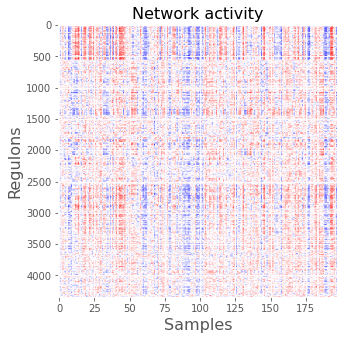

In [46]:
#visualize network activity across individual samples
plt.figure(figsize=(5,5))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

### Infer States

In [47]:
states,centroidClusters,states_dictionary = inferStates(expressionDataIvyAtlas,"IvyAtlas")

Beginning subtype inference
completed subtype inference in 0.05 minutes


### Infer States vs Programs

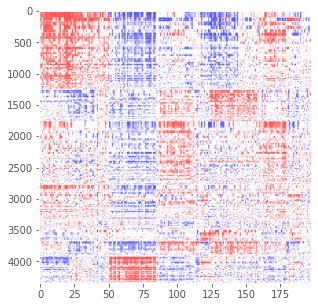

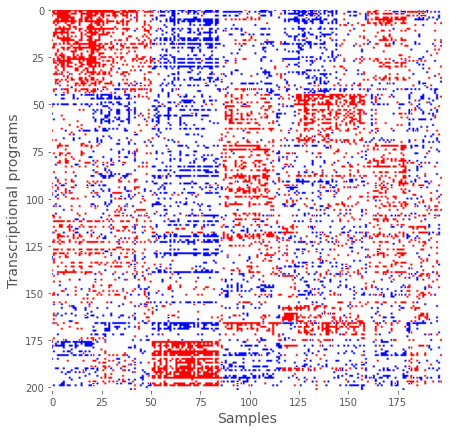

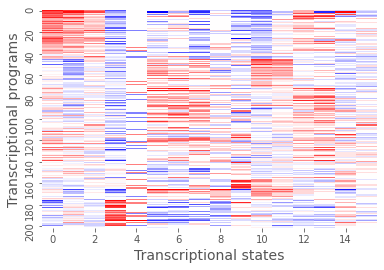

In [48]:
# load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(resultsDirectory,'transcriptional_programs.json'))

# run States vs Program inference
program_list, statesDf, programsVsStates = inferStatesvsPrograms(transcriptional_programs,"IvyAtlas")